# OOD Detection by CAE, RMD approach

This notebook demonstrates the process of detecting OOD images by using compressed images from CAE (see `train_autoencoder.ipynb` for details) and caclulating the Relative Mahalanobis Distance (RMD), which are then compared to a pre-computed threshold for OOD detection.   

RMD calculation was inspired by work in  ["**A Simple Fix to Mahalanobis Distance for Improving Near-OOD Detection**"](https://arxiv.org/abs/2106.09022) by Ren et.al.

 



## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Navigate to `ood-detection` repository

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Replace <OOD_DETECTION_REPOSITORY> with the correct location
os.chdir('/content/drive/<OOD_DETECTION_REPOSITORY>')
!git pull

## Build all datasets

Below we perform an 80/20 train/test split on the images in `ood-detection/data/bollworms-train/ID`. To train this model on a different dataset, simply change the directory inside the call to `find_image_files` below.

In [3]:
from data_utils.datasets import find_image_files, build_dataset

# Select dataset of interest
dataset = 'bollworms' # ['bollworms', 'bollworms-clean']

# These keyword arguments will be shared by all image datasets
ds_kwargs = {'cache': True, 'image_shape': (256, 256, 3), 'batch_size': 32, 'shuffle_buffer': 512}

# Build training sets of ID and OOD images
train_id_df = find_image_files(f'data/{dataset}-train/ID')
train_id_ds = build_dataset(train_id_df, augment=False, shuffle=False, **ds_kwargs)
train_ood_df = find_image_files(f'data/{dataset}-train/OOD')
train_ood_ds = build_dataset(train_ood_df, augment=False, shuffle=False, **ds_kwargs)

# Build testing sets of ID and OOD images
test_id_df = find_image_files(f'data/{dataset}-test/ID')
test_id_ds = build_dataset(test_id_df, augment=False, shuffle=False, **ds_kwargs)
test_ood_df = find_image_files(f'data/{dataset}-test/OOD')
test_ood_ds = build_dataset(test_ood_df, augment=False, shuffle=False, **ds_kwargs)

Found 7779 image files in folder "data/bollworms-train/ID"
Found 975 image files in folder "data/bollworms-train/OOD"
Found 865 image files in folder "data/bollworms-test/ID"
Found 108 image files in folder "data/bollworms-test/OOD"


## Load pre-trained autoencoder model

In [23]:
from models.autoencoder import Autoencoder

# Select model that is appropriate for the dataset
autoencoder = Autoencoder.load_model(name='20221130-Benchmark-IDEC') # bollworms
# autoencoder = Autoencoder.load_model(name='20221202-Benchmark-ID') # bollworms-clean

## Compute latent features at each layers of the autoencoder

In [ ]:
#Train
train_ds_dict = {'Train ID': train_id_ds, 'Train OOD': train_ood_ds}

train_latent_dicts = dict()
for layer in range(1, autoencoder.encode_blocks):
    train_latent_dicts[layer] = {label: autoencoder.get_latent_codes_at_layer(ds, layer) for label, ds in train_ds_dict.items()}

#Test
test_ds_dict = {'Test ID': test_id_ds, 'Test OOD': test_ood_ds}  

test_latent_dicts = dict()
for layer in range(1, autoencoder.encode_blocks):
    test_latent_dicts[layer] = {label: autoencoder.get_latent_codes_at_layer(ds, layer) for label, ds in test_ds_dict.items()}

# #save 
# np.save(f'{autoencoder.folder}/train_latent_dicts.npy', train_latent_dicts, allow_pickle=True)
# np.save(f'{autoencoder.folder}/test_latent_dicts.npy', test_latent_dicts, allow_pickle=True)

# #load
# np.load(f'{autoencoder.folder}/train_latent_dicts.npy', allow_pickle=True)
# np.load(f'{autoencoder.folder}/test_latent_dicts.npy', allow_pickle=True)


## Compute RMD for all datasets

The `relative_mahalanobis_distance` class allows for calculaton of RMD across layers, by switching parameter `layer`. We recommend calculation only over layers 3-7, where the number of features has been compressed suitably for the RMD calculation. 

A number of other parameters can be changed: 
1. `density_estimator`: {'BGM', 'GMM'} 
2. `bgm_gmm_covariance`: {‘tied’, ‘diag’, ‘spherical’} - The covariance of each mixture component. Note that 'full' covariance structure led to overparameterisation and was not implemented. 
3. `bgm_gmm_n_components`: The number of mixture components.

In [76]:
from models.rmd import relative_mahalanobis_distance

#assumptions
layer = 4
density_estimator = 'GMM' #BGM: Bayesian Gaussian mixture, GMM: GaussianMixture, 
bgm_gmm_covariance = 'diag' #{‘tied’, ‘diag’, ‘spherical’}
bgm_gmm_n_components = 10

#get RMD
rmd = relative_mahalanobis_distance(layer = layer , 
                        density_estimator = density_estimator, 
                        bgm_gmm_covariance = bgm_gmm_covariance, 
                        bgm_gmm_n_components = bgm_gmm_n_components, 
                        train_latent_dicts = train_latent_dicts,
                        test_latent_dicts = test_latent_dicts,
                        random_seed = 297)

rmd_train_ID, rmd_train_OOD, rmd_test_ID, rmd_test_OOD  = rmd.compute_RMD()

/usr/local/lib/python3.8/dist-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


## Visualize train density distribution with chosen hyperparameters 

Parameters:
layer: 4, density_estimator: GMM, covariance: diag, no. of components: 10 


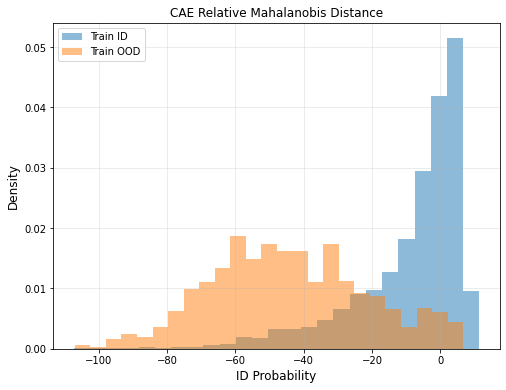

In [77]:
print('Parameters:')
print(f'layer: {layer}, density_estimator: {density_estimator}, covariance: {bgm_gmm_covariance}, no. of components: {bgm_gmm_n_components} ')
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rmd_train_ID, bins=25, alpha=0.5, density=True, label='Train ID')
ax.hist(rmd_train_OOD, bins=25, alpha=0.5, density=True, label='Train OOD')
ax.set_xlabel('ID Probability', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'CAE Relative Mahalanobis Distance')
ax.legend()
ax.grid(alpha=0.3)

## Find optimal threshold using train set

Our goal is the use weighted logistic regression to find the best threshold. We use weighted logistic regression to compute class probabilities rather than using the RMD scores directly because there is strong class imbalance in our train and test sets (train set is approximately 90% ID and 10% OOD). Here we fit a weighted logistic regression model to the RMD scores in the train set at each layer, and compute the threshold that maximizes the macro-averaged F1 score. We will then use the threshold that gives us the highest macro-averaged F1 score overall for our final analysis on the test set.

In [79]:
from analysis.classifiers import get_auroc, get_f1_maximizing_threshold, get_classification_report
from sklearn.linear_model import LogisticRegression

# Fit weighted logistic regression model to the training data
logit_model = LogisticRegression(penalty='none', class_weight='balanced')
x_train = np.concatenate([rmd_train_ID, rmd_train_OOD]).reshape(-1, 1)
y_train = np.concatenate([np.ones_like(rmd_train_ID), np.zeros_like(rmd_train_OOD)])
logit_model.fit(x_train, y_train)

# Compute model-predicted ID probabilities, which we treat as our new anomaly 
# detection scores. Then use these scores to find the threshold that maximizes 
# macro-averaged F1.
scores_train_id = logit_model.predict_proba(x_train[y_train == 1])[:, 1]
scores_train_ood = logit_model.predict_proba(x_train[y_train == 0])[:, 1]
threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)

print(f'max F1 score on train set = {max_f1_score:.3f}, ID probability threshold = {threshold:.3f}')

max F1 score on train set = 0.767, ID probability threshold = 0.259


## Use optimal threshold to evaluate on test set

Now that we have chosen our optimal threshold using the train set, we can finally evaluate our OOD detection performance on the test set. The output of this code cell was used to produce the primary table of results in our main report.

In [80]:
# Compute model-predicted ID probabilities on the test set using our best model.
x_test = np.concatenate([rmd_test_ID, rmd_test_OOD]).reshape(-1, 1)
y_test = np.concatenate([np.ones_like(rmd_test_ID), np.zeros_like(rmd_test_OOD)])
scores_test_id = logit_model.predict_proba(x_test[y_test == 1])[:, 1]
scores_test_ood = logit_model.predict_proba(x_test[y_test == 0])[:, 1]

# Compute and report all classifier metrics of interest 
auc = get_auroc(scores_test_id, scores_test_ood)
class_report, conf_matrix = get_classification_report(scores_test_id, scores_test_ood, threshold)
per_class_accuracy = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
tn, fp, fn, tp = conf_matrix.ravel()

print(f'Classification report on test set [layer: {layer}, Score: RMD]:')
print('')
print(class_report)
print(f'OOD accuracy: {per_class_accuracy[0]:.3f}')
print(f' ID accuracy: {per_class_accuracy[1]:.3f}')
print('')
print('Breakdown:', {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp})
print('')
print(f'AUC: {auc:.3f}')
print('')

Classification report on test set [layer: 4, Score: RMD]:

              precision    recall  f1-score   support

      OOD: 0      0.420     0.537     0.472       108
       ID: 1      0.940     0.908     0.924       865

    accuracy                          0.866       973
   macro avg      0.680     0.722     0.698       973
weighted avg      0.882     0.866     0.873       973

OOD accuracy: 0.537
 ID accuracy: 0.908

Breakdown: {'TN': 58, 'FP': 50, 'FN': 80, 'TP': 785}

AUC: 0.859



## Visualize test set performance

Parameters:
layer: 4, density_estimator: GMM, covariance: diag, no. of components: 10 


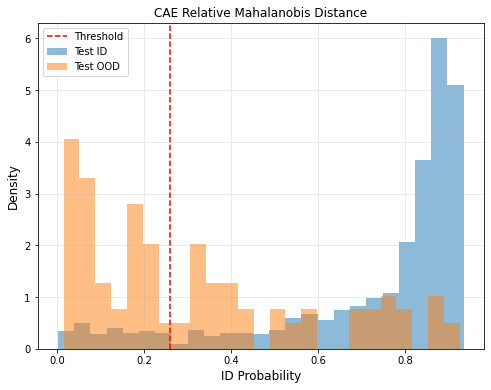

In [81]:
# First in terms of ID probabilities from weighted logistic regression model
print('Parameters:')
print(f'layer: {layer}, density_estimator: {density_estimator}, covariance: {bgm_gmm_covariance}, no. of components: {bgm_gmm_n_components} ')
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(scores_test_id, bins=25, alpha=0.5, density=True, label='Test ID')
ax.hist(scores_test_ood, bins=25, alpha=0.5, density=True, label='Test OOD')
ax.axvline(threshold, color='r', linestyle='--', label='Threshold')
ax.set_xlabel('ID Probability', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'CAE Relative Mahalanobis Distance')
ax.legend()
ax.grid(alpha=0.3)

Parameters:
layer: 4, density_estimator: GMM, covariance: diag, no. of components: 10 


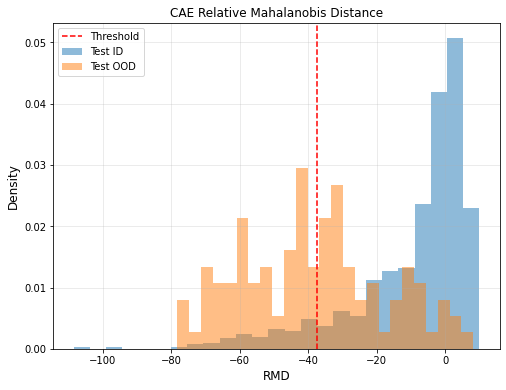

In [82]:
# Then on the original scale in terms of loglikelihood values
print('Parameters:')
print(f'layer: {layer}, density_estimator: {density_estimator}, covariance: {bgm_gmm_covariance}, no. of components: {bgm_gmm_n_components} ')
logit = lambda p: np.log(p/(1-p))
threshold_loglikelihood = ((logit(threshold) - logit_model.intercept_)/logit_model.coef_[0][0])[0]
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rmd_test_ID, bins=25, alpha=0.5, density=True, label='Test ID')
ax.hist(rmd_test_OOD, bins=25, alpha=0.5, density=True, label='Test OOD') 
ax.axvline(threshold_loglikelihood, color='r', linestyle='--', label='Threshold')
ax.set_xlabel('RMD', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'CAE Relative Mahalanobis Distance')
ax.legend()
ax.grid(alpha=0.3)

##Evaluate on external OOD datasets


If present in the `ood-detection/data` folder, we can also evaluate our classifier on the `stanford_dogs` and `flowers102` datasets.

In [83]:
from data_utils.datasets import find_image_files, build_dataset

# Randomly sample this many images from each external OOD dataset below
num_images = 3000

# These keyword arguments will be shared by all image datasets
ds_kwargs = {'cache': True, 'image_shape': (256, 256, 3), 'batch_size': 32, 'shuffle_buffer': 512}

# Build stanford dogs dataset
stanford_dogs_df = find_image_files('data/stanford_dogs/Images/*')
stanford_dogs_df = stanford_dogs_df.sample(frac=1, random_state=297).iloc[:num_images]
stanford_dogs_ds = build_dataset(stanford_dogs_df, augment=False, shuffle=False, **ds_kwargs)

# Build flowers102 dataset
flowers102_df = find_image_files('data/flowers102/jpg')
flowers102_df = flowers102_df.sample(frac=1, random_state=297).iloc[:num_images]
flowers102_ds = build_dataset(flowers102_df, augment=False, shuffle=False, **ds_kwargs)

# Combine them into one external dataset dictionary object
external_ds_dict = {'Dogs': stanford_dogs_ds, 'Flowers': flowers102_ds}

Found 20580 image files in folder "data/stanford_dogs/Images/*"
Found 1620 image files in folder "data/flowers102/jpg"


## Compute latent features at each layers of the autoencoder

In [84]:
# Select dataset of interest
external_dataset = 'Dogs' # ['Dogs', 'Flowers']
external_ds = external_ds_dict[external_dataset]

#Test
test_ds_dict = {'Test ID': external_ds, 'Test OOD': external_ds}  

test_latent_dicts = dict()
for layer in range(1, autoencoder.encode_blocks):
    test_latent_dicts[layer] = {label: autoencoder.get_latent_codes_at_layer(ds, layer) for label, ds in test_ds_dict.items()}

## Compute RMD for external dataset

In [93]:
from models.rmd import relative_mahalanobis_distance

#assumptions
layer = 4
density_estimator = 'GMM' #BGM: Bayesian Gaussian mixture, GMM: GaussianMixture, 
bgm_gmm_covariance = 'diag' #{‘tied’, ‘diag’, ‘spherical’}
bgm_gmm_n_components = 10

#get RMD
rmd = relative_mahalanobis_distance(layer = layer , 
                        density_estimator = density_estimator, 
                        bgm_gmm_covariance = bgm_gmm_covariance, 
                        bgm_gmm_n_components = bgm_gmm_n_components, 
                        train_latent_dicts = train_latent_dicts,
                        test_latent_dicts = test_latent_dicts,
                        random_seed = 297)

rmd_train_ID, rmd_train_OOD, rmd_test_ID, rmd_test_OOD  = rmd.compute_RMD()

/usr/local/lib/python3.8/dist-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


## Accuracy for external datasets

In [99]:
from sklearn.metrics import classification_report

# Compute model-predicted ID probabilities on the test set using our best model.
x_test = np.concatenate([rmd_test_OOD]).reshape(-1, 1)
y_test = np.concatenate([np.zeros_like(rmd_test_OOD)])

#Compute accuracy 
scores_test_ood = logit_model.predict_proba(x_test[y_test == 0])[:, 1]
external_ood_accuracy = 1.0 - np.mean(scores_test_ood > threshold)
print(f'{external_dataset} dataset (OOD) accuracy: {external_ood_accuracy:.3f}')

Dogs dataset (OOD) accuracy: 0.896
